In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import shap
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.datasets import make_classification
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.model_selection import GridSearchCV

In [4]:
def load_data(file_paths):
    dataframes = {key: pd.read_csv(path) for key, path in file_paths.items()}
    dataframes["treatment_1"]["label"] = 1
    dataframes["treatment_2"]["label"] = 2
    dataframes["control"]["label"] = 0
    df = pd.concat(dataframes.values(), ignore_index=True)
    df = df[df["image_name"].str.contains("-ch2")]
    # df = df[df["num_projections"] != 0] # optional, filtering out no projections
    return df.drop(columns=["image_name", "astrocyte", "mask"])

In [5]:
def preprocess_data(df):
    X = df.drop(columns=["label"])
    y = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = np.log1p(X_train), np.log1p(X_test)
    scaler = StandardScaler()
    return X, y, scaler.fit_transform(X_train), scaler.transform(X_test), y_train, y_test, X.columns

In [6]:
# trains selected model and returns: accuracy, f1 score, regular feature importance, and shap values
def train_and_evaluate(model_name, X_train, X_test, y_train, y_test, feature_names):

    if model_name == "LR":
        model = LogisticRegression()
    elif model_name == "Ridge":
        model = RidgeClassifier(alpha=1)
    elif model_name == "ENet":
        model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.3, max_iter=10000)
    elif model_name == "XGBoost":
        model = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
    elif model_name == "RF":
        model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42, oob_score=True)
    else:
        return("Undefined model")

    # NOTE: these were the columns to drop based on Ethan's binarize (only appicable to Ridge and Logistic Regression), but may need to experiment based on VIF and model accuracy
    if model_name == "Ridge":
        drop_cols = ["num_edges", "total_branch_length", "avg_branch_length", "avg_projection_length", "length_width_ratio"]
    elif model_name == "LR":
        drop_cols = ["num_edges", "total_branch_length", "avg_branch_length", "avg_projection_length", "length_width_ratio", "circularity"]
    else:
        drop_cols = []

    X_train_filtered = pd.DataFrame(X_train, columns=feature_names).drop(columns=drop_cols, errors='ignore')
    X_test_filtered = pd.DataFrame(X_test, columns=feature_names).drop(columns=drop_cols, errors='ignore')
    model.fit(X_train_filtered, y_train)
    y_pred = model.predict(X_test_filtered)
    accuracy, f1 = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')
    feature_importance = model.coef_[0] if hasattr(model, "coef_") else model.feature_importances_

    # Compute SHAP values based on model type
    if isinstance(model, RandomForestClassifier) or isinstance(model, xgb.XGBClassifier):
        # TreeExplainer for Tree-based models (RF, XGBoost)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_filtered)
    else:
        # KernelExplainer for linear models (Ridge, Logistic, Elastic Net)
        background_samples = shap.sample(X_train_filtered, 100)
        if hasattr(model, 'decision_function'):  # For models like Ridge and ElasticNet
            explainer = shap.KernelExplainer(model.decision_function, background_samples)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, background_samples)
        shap_values = explainer.shap_values(X_test_filtered)
        
    return accuracy, f1, feature_importance, shap_values

In [7]:
file_paths = {"treatment_1": "../features/treatment1_features.csv", "treatment_2": "../features/treatment2_features.csv", "control": "../features/control_features.csv"}
df = load_data(file_paths)
X, y, X_train, X_test, y_train, y_test, feature_names = preprocess_data(df)

In [8]:
# VIF values, used to determine what columns to drop (need recursive experimentation)
X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)

def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = compute_vif(X_train_scaled_df)
vif_df = vif_df.sort_values(by="VIF", ascending=False)

print(vif_df)

                  Feature          VIF
13              num_edges  1376.860325
9     total_branch_length  1014.043620
12              num_nodes   660.699466
10      avg_branch_length   259.059906
1               perimeter   193.907301
3   avg_projection_length   173.379957
4   max_projection_length   153.800757
0                    area   111.575510
14     avg_euclidean_dist    63.236830
8             fractal_dim    57.512696
11      max_branch_length    54.031704
2         num_projections    44.212118
5             circularity    35.934145
7      length_width_ratio     1.335551
6               neighbors     1.170103


Accuracy: 0.3988
F1 Score: 0.3986


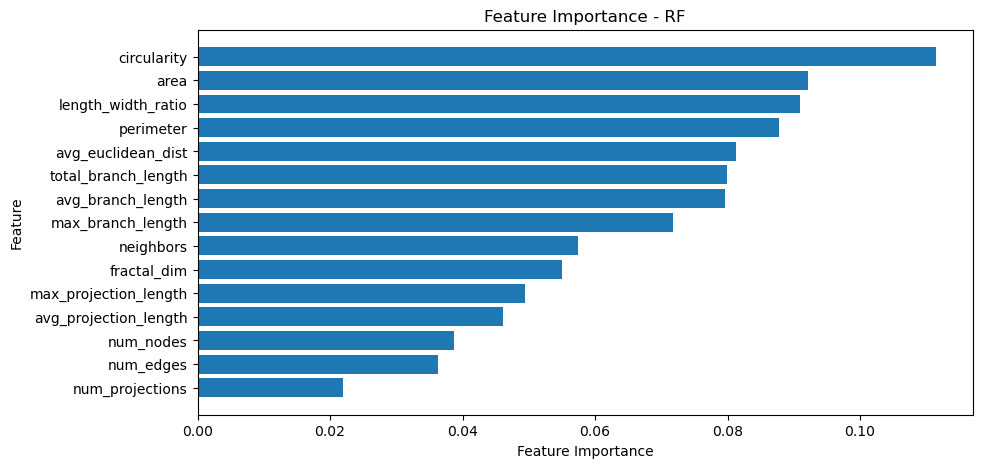

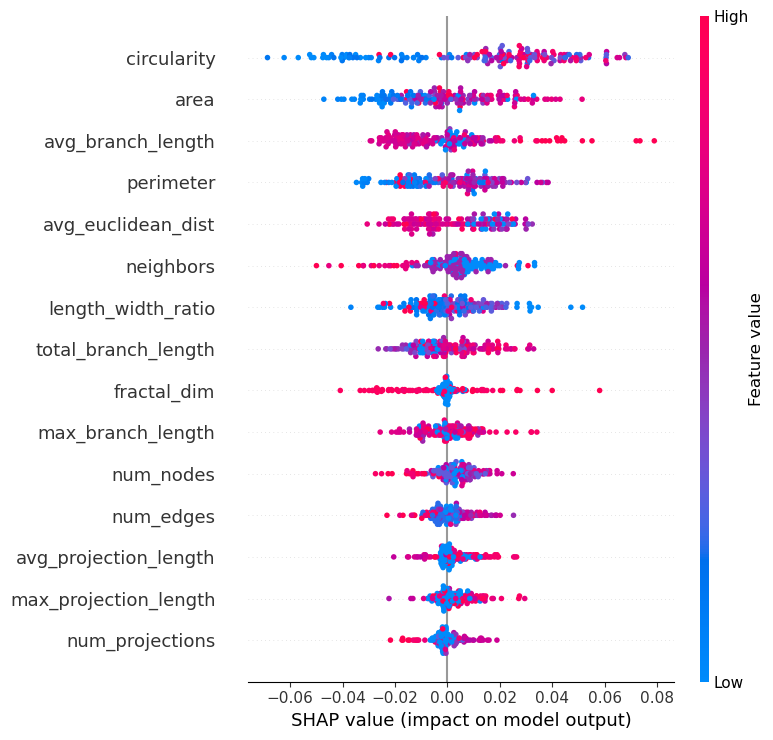

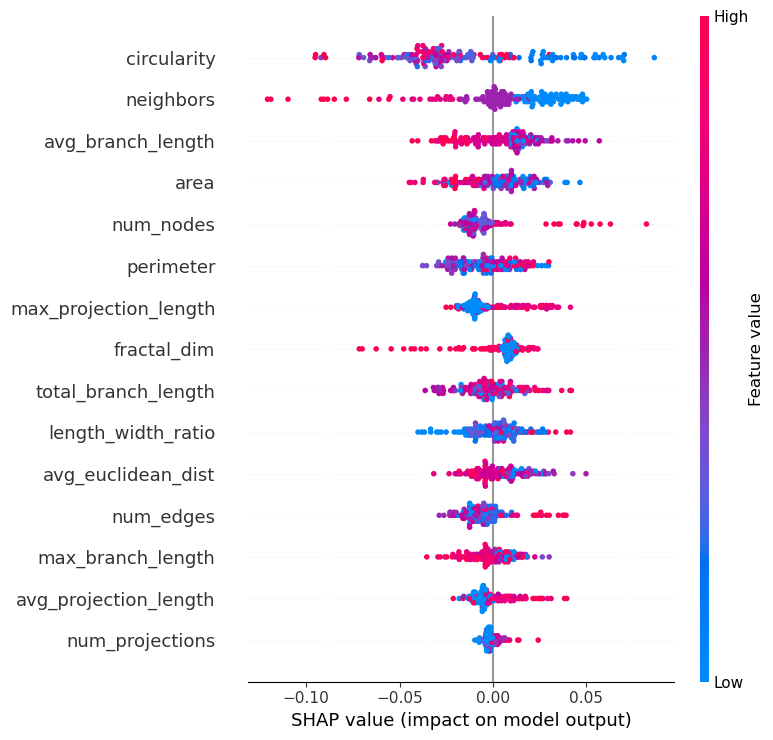

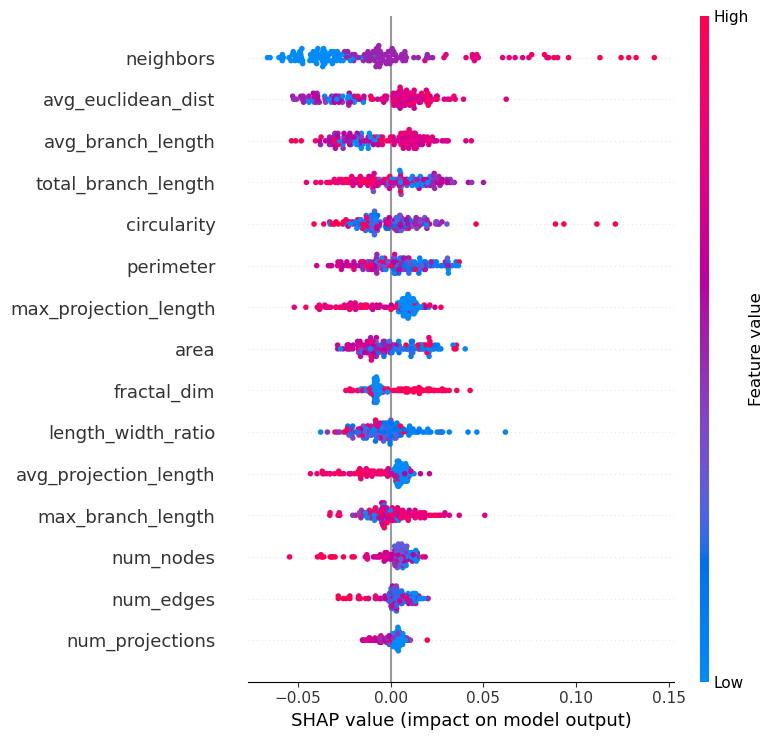

In [9]:
# Select model you want in first parameter, currently random forest
# model_name = "LR" # logistic regession
# model_name = "Ridge"
# model_name = "ENet" # elastic net
# model_name = "XGBoost" 
model_name = "RF" # random forest
accuracy, f1, feature_importance, shap_values = train_and_evaluate(model_name, X_train, X_test, y_train, y_test, feature_names)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

importance_df= pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], align="center")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Feature Importance - {model_name}")
plt.gca().invert_yaxis()
plt.show()

shap.summary_plot(shap_values[:,:,0], X_test, X.columns.tolist(), show=True) # Control
shap.summary_plot(shap_values[:,:,1], X_test, X.columns.tolist(), show=True) # Treatment1
shap.summary_plot(shap_values[:,:,2], X_test, X.columns.tolist(), show=True) # Treatment2

# shap.summary_plot(shap_values[:,:,0], X_test, plot_type="bar", feature_names=X.columns.tolist()) # Optional shap bar plot, set indices like above shap plots